#### Challenge 1   
  
- Open up a new IPython notebook
- Download a few MTA turnstile data files
- Open up a file, use csv reader to read it and ensure there is a column for each feature (C/A, UNIT, SCP, STATION). These are the first four columns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
#import pymc3 as pm
import seaborn as sns
import dateutil.parser
import datetime
from datetime import timedelta
from datetime import date
import calendar

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


#bişi ekledim
# ben ugur ekledim.
# yeni ekledim
# xywzfhgdhdf

In [2]:
# Choose to download(True) or read from file (False)
download = False

if download:
    dates = ['180505','180512','180519','180526']

    M_data = []
    for wk_date in dates:
        MTA_url = f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{wk_date}.txt"
        M_data.append(pd.read_csv(MTA_url))
        
    MTA_data = pd.concat(M_data)
    MTA_data.to_csv('turnstile_backup.csv')
else:
    MTA_data = pd.read_csv("turnstile_backup.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'turnstile_backup.csv'

In [3]:
# so it's easier to deal with, rename C/A to CA and drop unused columns
MTA_data.rename(index=str, columns={"C/A": "CA"})
MTA_data.rename(columns={"C/A": "CA"},inplace=True)
MTA_data.drop(['LINENAME', 'DIVISION','DESC'], axis=1,inplace=True)
MTA_data.head(10)



,Unnamed: 0,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS
0,0,A002,R051,02-00-00,59 ST,04/28/2018,00:00:00,6598847,2235829
1,1,A002,R051,02-00-00,59 ST,04/28/2018,04:00:00,6598864,2235830
2,2,A002,R051,02-00-00,59 ST,04/28/2018,08:00:00,6598880,2235863
3,3,A002,R051,02-00-00,59 ST,04/28/2018,12:00:00,6598961,2235955
4,4,A002,R051,02-00-00,59 ST,04/28/2018,16:00:00,6599175,2236015
5,5,A002,R051,02-00-00,59 ST,04/28/2018,20:00:00,6599456,2236074
6,6,A002,R051,02-00-00,59 ST,04/29/2018,00:00:00,6599584,2236102
7,7,A002,R051,02-00-00,59 ST,04/29/2018,04:00:00,6599593,2236106
8,8,A002,R051,02-00-00,59 ST,04/29/2018,08:00:00,6599603,2236123
9,9,A002,R051,02-00-00,59 ST,04/29/2018,12:00:00,6599689,2236180


In [4]:
#reset the row indices
MTA_data.reset_index(inplace=True, drop=True)

In [5]:
MTA_data.columns

Index(['Unnamed: 0', 'CA', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [6]:
# fix the EXITS column name to remove white space
MTA_data.columns = MTA_data.columns.str.strip()
MTA_data.columns

Index(['Unnamed: 0', 'CA', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES',
       'EXITS'],
      dtype='object')

#### Challenge 2

- Let's turn this into a time series.

Create a new column that specifies the date and time of each entry.

You can convert the date and time into datetime objects
-- That is a python class that represents a point in time. You can
combine the date and time fields into a string and use the
[dateutil](https://labix.org/python-dateutil) module to convert it
into a datetime object. For an example check
[this StackOverflow question](http://stackoverflow.com/questions/23385003/attri\
buteerror-when-using-import-dateutil-and-dateutil-parser-parse-but-no).

Also, check out this handy [Pandas function](https://pandas.pydata.org/pandas-d\
ocs/stable/generated/pandas.to_datetime.html).

In [7]:
#combine the DATE and TIME fields and parse the datetime then add this as a column to the dataframe
MTA_data['datetime'] = MTA_data.apply(lambda row: dateutil.parser.parse(row.DATE + ' ' + row.TIME), axis=1)

MTA_data.head()

,Unnamed: 0,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,datetime
0,0,A002,R051,02-00-00,59 ST,04/28/2018,00:00:00,6598847,2235829,2018-04-28 00:00:00
1,1,A002,R051,02-00-00,59 ST,04/28/2018,04:00:00,6598864,2235830,2018-04-28 04:00:00
2,2,A002,R051,02-00-00,59 ST,04/28/2018,08:00:00,6598880,2235863,2018-04-28 08:00:00
3,3,A002,R051,02-00-00,59 ST,04/28/2018,12:00:00,6598961,2235955,2018-04-28 12:00:00
4,4,A002,R051,02-00-00,59 ST,04/28/2018,16:00:00,6599175,2236015,2018-04-28 16:00:00


#### Challenge 3

- These counts are for every n hours. (What is n?) We want total daily
  entries.

Calculate to total daily entries for each turnstile.

Your result should be a new data frame that has the same keys, but now we have \
a single
value for a single day, which is the total number of passengers that
entered through this turnstile on this day.

In [32]:
# sort by STATION, UNIT, CA, SCP, datetime in this order
MTA_data.sort_values(by = ['STATION','UNIT','CA','SCP','datetime'], inplace=True)

In [33]:
MTA_data.head()

,Unnamed: 0,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,datetime,entry_diff,exit_diff
30193,30193,H007,R248,00-00-00,1 AV,04/28/2018,00:00:00,13470157,15068968,2018-04-28 00:00:00,90.0,294.0
30194,30194,H007,R248,00-00-00,1 AV,04/28/2018,04:00:00,13470247,15069262,2018-04-28 04:00:00,89.0,321.0
30195,30195,H007,R248,00-00-00,1 AV,04/28/2018,08:00:00,13470336,15069583,2018-04-28 08:00:00,546.0,1039.0
30196,30196,H007,R248,00-00-00,1 AV,04/28/2018,12:00:00,13470882,15070622,2018-04-28 12:00:00,741.0,1288.0
30197,30197,H007,R248,00-00-00,1 AV,04/28/2018,16:00:00,13471623,15071910,2018-04-28 16:00:00,693.0,1560.0


In [34]:
#create a new column whith the difference between the previous day's ENTRIES and the current day's ENTRIES                                  .diff(periods=-1) * -1)
MTA_data['entry_diff'] = (MTA_data.groupby(['STATION','UNIT','CA','SCP'])
                                    ['ENTRIES']
                                    .diff(periods=-1)) * -1


In [35]:
#create a new column whith the difference between the previous day's EXITS and the current day's EXITS

MTA_data['exit_diff'] = (MTA_data.groupby(['STATION','UNIT','CA','SCP'])
                                    ['EXITS']
                                    .diff(periods=-1)) * -1

In [36]:
MTA_data.head(30)

,Unnamed: 0,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,datetime,entry_diff,exit_diff
30193,30193,H007,R248,00-00-00,1 AV,04/28/2018,00:00:00,13470157,15068968,2018-04-28 00:00:00,90.0,294.0
30194,30194,H007,R248,00-00-00,1 AV,04/28/2018,04:00:00,13470247,15069262,2018-04-28 04:00:00,89.0,321.0
30195,30195,H007,R248,00-00-00,1 AV,04/28/2018,08:00:00,13470336,15069583,2018-04-28 08:00:00,546.0,1039.0
30196,30196,H007,R248,00-00-00,1 AV,04/28/2018,12:00:00,13470882,15070622,2018-04-28 12:00:00,741.0,1288.0
30197,30197,H007,R248,00-00-00,1 AV,04/28/2018,16:00:00,13471623,15071910,2018-04-28 16:00:00,693.0,1560.0
30198,30198,H007,R248,00-00-00,1 AV,04/28/2018,20:00:00,13472316,15073470,2018-04-28 20:00:00,505.0,1022.0
30199,30199,H007,R248,00-00-00,1 AV,04/29/2018,00:00:00,13472821,15074492,2018-04-29 00:00:00,112.0,296.0
30200,30200,H007,R248,00-00-00,1 AV,04/29/2018,04:00:00,13472933,15074788,2018-04-29 04:00:00,62.0,226.0
30201,30201,H007,R248,00-00-00,1 AV,04/29/2018,08:00:00,13472995,15075014,2018-04-29 08:00:00,446.0,717.0
30202,30202,H007,R248,00-00-00,1 AV,04/29/2018,12:00:00,13473441,15075731,2018-04-29 12:00:00,586.0,1179.0


In [37]:
MTA_data['entry_diff'].min()
MTA_data['entry_diff'].max()

2065205244.0

In [38]:
MTA_data = MTA_data[(MTA_data['entry_diff'] >= 0)
                  & (MTA_data['entry_diff'] < 30000)
                  & (MTA_data['exit_diff'] >= 0)
                  & (MTA_data['exit_diff'] < 30000)]

In [42]:
# The data currently has the turnstile differences on the 4 hour time ranges.  
# Now combine to come up with a daily count

MTA_data_daysummary = MTA_data.groupby(['CA','SCP','DATE'])['entry_diff'].sum().reset_index()
MTA_data_daysummary.head()

,CA,SCP,DATE,entry_diff
0,A002,02-00-00,04/28/2018,737.0
1,A002,02-00-00,04/29/2018,575.0
2,A002,02-00-00,04/30/2018,1603.0
3,A002,02-00-00,05/01/2018,1512.0
4,A002,02-00-00,05/02/2018,1513.0


#### Challenge 4

Now plot the daily time series for a turnstile.

In [16]:
MTA_SCP = MTA_data_daysummary[(MTA_data_daysummary['CA'] == 'A002')
                            & (MTA_data_daysummary['SCP'] == '02-00-00')]

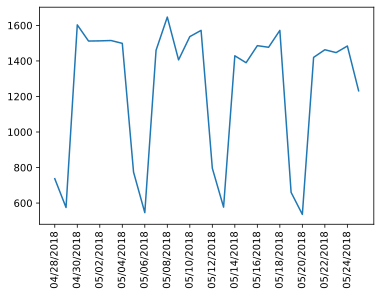

In [17]:
x = MTA_SCP.DATE; y = MTA_SCP.entry_diff
plt.plot(x, y)
plt.xticks(range(0, len(x), 2), MTA_SCP.DATE[::2], rotation=90)
plt.show()


#### Challenge 5

- So far we've been operating on a single turnstile level, let's
  combine turnstiles in the same ControlArea/Unit/Station combo. There
  are some ControlArea/Unit/Station groups that have a single
  turnstile, but most have multiple turnstilea-- same value for the
  C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each
ControlArea/UNIT/STATION combo, for each day, add the counts from each
turnstile belonging to that combo.

In [18]:
MTA_data_CA_entry = MTA_data.groupby(['CA','UNIT','STATION','DATE'])['entry_diff'].sum().reset_index()
MTA_data_CA_exit  = MTA_data.groupby(['CA','UNIT','STATION','DATE'])['exit_diff'].sum().reset_index()

MTA_data_CA_entry.head()

,CA,UNIT,STATION,DATE,entry_diff
0,A002,R051,59 ST,04/28/2018,7852.0
1,A002,R051,59 ST,04/29/2018,6339.0
2,A002,R051,59 ST,04/30/2018,13666.0
3,A002,R051,59 ST,05/01/2018,13794.0
4,A002,R051,59 ST,05/02/2018,14032.0


###### Challenge 6

Similarly, combine everything in each station, and come up with a time
series of `[(date1, count1),(date2,count2),...]` type of time series
for each STATION, by adding up all the turnstiles in a station.

In [19]:
MTA_data_Station_entry = MTA_data.groupby(['STATION','DATE'])['entry_diff'].sum().reset_index()
MTA_data_Station_exit  = MTA_data.groupby(['STATION','DATE'])['exit_diff'].sum().reset_index()

MTA_data_Station_entry.head()

,STATION,DATE,entry_diff
0,1 AV,04/28/2018,20139.0
1,1 AV,04/29/2018,15331.0
2,1 AV,04/30/2018,21710.0
3,1 AV,05/01/2018,22367.0
4,1 AV,05/02/2018,23148.0


#### Challenge 7

Plot the time series (either daily or your preferred level of granularity) for a station.

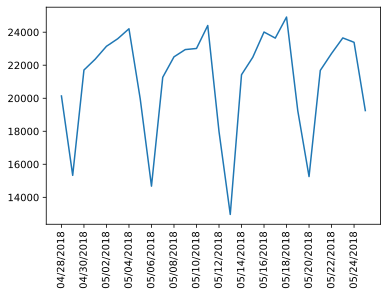

In [20]:
MTA_Station = MTA_data_Station_entry[(MTA_data_Station_entry['STATION'] == '1 AV')]

x = MTA_Station.DATE; y = MTA_Station.entry_diff
plt.plot(x, y)
plt.xticks(range(0, len(x), 2), MTA_Station.DATE[::2], rotation=90)
plt.show()

#### Challenge 8

Select a station and find the total daily counts for this station. Then plot those daily counts for each week separately.

To clarify: if I have 10 weeks of data on the 28th st 6 station, I will add 10 lines to the same figure (e.g. running `plt.plot(week_count_list)` once for each week). Each plot will have 7 points of data.

In [21]:
# for each day and station, find the daily total for entries and exits
MTA_data_Station_entry = MTA_data.groupby(['STATION','DATE','datetime'])['entry_diff'].sum().reset_index()
MTA_data_Station_exit  = MTA_data.groupby(['STATION','DATE','datetime'])['exit_diff'].sum().reset_index()

MTA_data_Station_entry.head()

,STATION,DATE,datetime,entry_diff
0,1 AV,04/28/2018,2018-04-28 00:00:00,1468.0
1,1 AV,04/28/2018,2018-04-28 04:00:00,598.0
2,1 AV,04/28/2018,2018-04-28 08:00:00,2856.0
3,1 AV,04/28/2018,2018-04-28 12:00:00,5368.0
4,1 AV,04/28/2018,2018-04-28 16:00:00,5501.0


In [22]:
# for a chosen station, find the earliest and latest date.
plt_Station = '1 AV'
first_date = pd.to_datetime(MTA_data[MTA_data['STATION'] == plt_Station].DATE.min())
last_date  = pd.to_datetime(MTA_data[MTA_data['STATION'] == plt_Station].DATE.max())

d = first_date
plt_first_dates = []
while d <= last_date:
    plt_first_dates.append(d)
    d += timedelta(days=7)


In [23]:
MTA_data_Station_entry_daily = (MTA_data_Station_entry[MTA_data_Station_entry['STATION']== plt_Station]
                                .groupby(['DATE'])['entry_diff'].sum().reset_index())

In [24]:
MTA_data_Station_entry_daily['datetime'] = pd.to_datetime(MTA_data_Station_entry_daily.DATE)
MTA_data_Station_entry_daily.drop(['DATE'],axis=1,inplace=True)

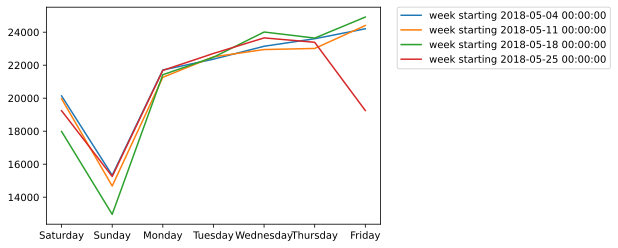

In [25]:
for d in plt_first_dates:
    y = (MTA_data_Station_entry_daily[((MTA_data_Station_entry_daily['datetime'] >= d)
                                     & (MTA_data_Station_entry_daily['datetime'] < d+timedelta(days=7)))].entry_diff)
    x_date = (MTA_data_Station_entry_daily[((MTA_data_Station_entry_daily['datetime'] >= d)
                                          & (MTA_data_Station_entry_daily['datetime'] < d+timedelta(days=7)))].datetime)
    x = []
    for d in x_date:
        x.append(calendar.day_name[d.weekday()])
    plt.plot(x, y,label=f'week starting {d}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#### Challenge 9

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [26]:
MTA_data_Station_entry = MTA_data.groupby(['STATION'])['entry_diff'].sum().reset_index()
MTA_data_Station_entry.sort_values(by=['entry_diff'],ascending=False,inplace=True)

In [27]:
MTA_data_Station_entry.head(10)

,STATION,entry_diff
59,34 ST-PENN STA,4038742.0
230,GRD CNTRL-42 ST,3484634.0
45,23 ST,2825971.0
57,34 ST-HERALD SQ,2794689.0
14,14 ST-UNION SQ,2706239.0
350,TIMES SQ-42 ST,2516191.0
223,FULTON ST,2372369.0
65,42 ST-PORT AUTH,2272380.0
107,86 ST,2124044.0
83,59 ST COLUMBUS,1913639.0


In [28]:
MTA_data_Station_exit  = MTA_data.groupby(['STATION'])['exit_diff'].sum().reset_index()
MTA_data_Station_exit.sort_values(by=['exit_diff'],ascending=False,inplace=True)

In [29]:
MTA_data_Station_exit.head(10)

,STATION,exit_diff
59,34 ST-PENN STA,3468128.0
230,GRD CNTRL-42 ST,3162735.0
57,34 ST-HERALD SQ,2558278.0
350,TIMES SQ-42 ST,2338989.0
14,14 ST-UNION SQ,2335400.0
45,23 ST,2013007.0
223,FULTON ST,1936616.0
65,42 ST-PORT AUTH,1840823.0
107,86 ST,1778180.0
83,59 ST COLUMBUS,1550975.0


#### Challenge 10

- Make a single list of these total ridership values and plot it with

    plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among
different stations.

This should show you that most stations have a small traffic, and the
histogram bins for large traffic volumes have small bars.

*Additional Hint*:

If you want to see which stations take the meat of the traffic, you
can sort the total ridership counts and make a `plt.bar` graph. For
this, you want to have two lists: the indices of each bar, and the
values. The indices can just be `0,1,2,3,...`, so you can do

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)

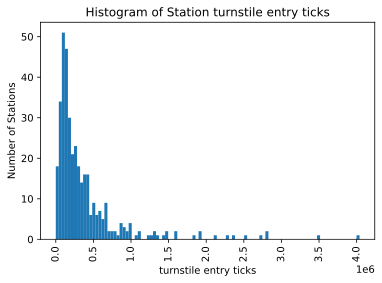

In [30]:
# Histogram showing the number of stations with a given number of entry ticks
plt.xticks(rotation=90)
plt.title('Histogram of Station turnstile entry ticks', fontsize= 12)
plt.xlabel('turnstile entry ticks', fontsize= 10)
plt.ylabel('Number of Stations',fontsize=10,rotation=90)
plt.hist(MTA_data_Station_entry['entry_diff'],100);

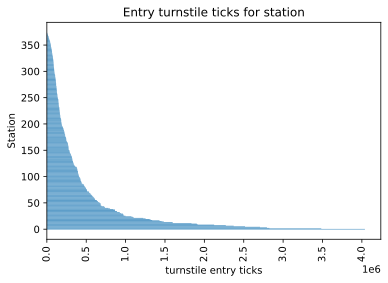

In [31]:
# For each station, the turnstile entry ticks
x = MTA_data_Station_entry['entry_diff']
indices = range(len(MTA_data_Station_entry))
plt.barh(indices, x)
plt.xticks(rotation=90)
plt.title('Entry turnstile ticks for station', fontsize= 12)
plt.xlabel('turnstile entry ticks', fontsize= 10)
plt.ylabel('Station', fontsize=10)
plt.show()